In [1]:
#Cell_1.
# -*- coding: utf-8 -*-
import os
import cv2
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix

import tensorflow
seedval = 13
tensorflow.random.set_seed(seedval)
np.random.seed(seedval)
random.seed(seedval)
os.environ["PYTHONHASHSEED"] = str(seedval)

2024-11-19 23:16:59.115109: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kali/anaconda3/envs/ds2024/lib/python3.7/site-packages/cv2/../../lib64:
2024-11-19 23:16:59.115132: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#Cell_2.
IMAGESIZE = 64  #読み込んだ画像は(IMAGESIZE,IMAGESIZE)のサイズにリサイズする

# ディレクトリ内の画像を読み込む
# inputpath: ディレクトリ文字列, imagesize: 画像サイズ, type_color: ColorかGray
def load_images(inputpath, imagesize, type_color):
    imglist = []
    filenamelist = []

    for root, dirs, files in os.walk(inputpath):
        for fn in sorted(files):
            bn, ext = os.path.splitext(fn)
            if ext not in [".bmp", ".BMP", ".jpg", ".JPG", ".jpeg", ".JPEG", ".png", ".PNG"]:
                continue

            filename = os.path.join(root, fn)
            
            if type_color == 'Color':
                # カラー画像の場合
                testimage = cv2.imread(filename, cv2.IMREAD_COLOR)
                # サイズ変更
                height, width = testimage.shape[:2]
                testimage = cv2.resize(testimage, (imagesize, imagesize), interpolation = cv2.INTER_AREA)  #主に縮小するのでINTER_AREA使用
                testimage = np.asarray(testimage, dtype=np.float64)
                # 色チャンネル，高さ，幅に入れ替え．data_format="channels_first"を使うとき必要
                #testimage = testimage.transpose(2, 0, 1)
                # チャンネルをbgrの順からrgbの順に変更
                testimage = testimage[:,:,::-1]
            
            elif type_color == 'Gray':
                # グレースケール画像の場合
                testimage = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
                # サイズ変更
                height, width = testimage.shape[:2]
                testimage = cv2.resize(testimage, (imagesize, imagesize), interpolation = cv2.INTER_AREA)  #主に縮小するのでINTER_AREA使用
                # チャンネルの次元がないので1次元追加する
                testimage = np.asarray([testimage], dtype=np.float64)
                testimage = np.asarray(testimage, dtype=np.float64).reshape((imagesize, imagesize, 1))
                # チャンネル，高さ，幅に入れ替え．data_format="channels_first"を使うとき必要
                #testimage = testimage.transpose(2, 0, 1)

            imglist.append(testimage)
            filenamelist.append(fn)
    imgsdata = np.asarray(imglist, dtype=np.float32)

    return imgsdata, filenamelist  # 画像リストとファイル名のリストを返す


In [3]:
#Cell_3.
#%%
### データ準備 ###
print('*** Loading images ***')

# 画像読み込みとラベル値作成
# クラス0
image0, filenames_image0 = load_images('./sundatabase_negative/', IMAGESIZE, 'Color')
label0 = np.full(image0.shape[0], 0)    #画像数と同数のラベル値を含むリスト

# クラス1
image1, filenames_image1 = load_images('./sundatabase_positive/', IMAGESIZE, 'Color')
label1 = np.full(image1.shape[0], 1)    #画像数と同数のラベル値を含むリスト


# 画像，ラベル値，ファイル名それぞれ1つの配列にまとめる
image_all = np.concatenate([image0, image1], axis=0)
label_all = np.append(label0, label1)
filename_all = filenames_image0 + filenames_image1


*** Loading images ***


In [4]:
#Cell_4.
indices = np.array(range(image_all.shape[0]))
image_train, image_test, label_train, label_test, index_train, index_test = train_test_split(image_all, label_all, indices, test_size=0.2)

In [5]:
#Cell_5.
print(indices)
print(len(label_train))
print(len(label_test))

[   0    1    2 ... 1810 1811 1812]
1450
363


In [6]:
#Cell_6.
# testデータのファイル名リスト作成
filenames_test = []
for i in range(len(index_test)):
    filenames_test.append(filename_all[index_test[i]])


# 画像の画素値を0-1に正規化
image_train /= 255.0
image_test /= 255.0

# ラベルをone hot vector形式に変換
label_train_binary = to_categorical(label_train)
label_test_binary = to_categorical(label_test)

print('Loaded images: ' + repr(image_train.shape[0]) + ' for training and ' + repr(image_test.shape[0]) + ' for testing.')


Loaded images: 1450 for training and 363 for testing.


In [7]:
#Cell_7.
### 画像分類モデル定義と学習処理の実行 ###
print('*** Training ***')

# 層の数を増やした分類CNN
def classification_model_deep1():
    input_img = Input(shape=(IMAGESIZE, IMAGESIZE, 3))

    x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same')(input_img)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=4, strides=4)(x)

    x = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=4, strides=4)(x)

    x = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=4, strides=4)(x)
    
    x = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(x)
    x = Activation('relu')(x)
    x
    
    x = Flatten()(x)

    x = Dense(100)(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(10)(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(2)(x)
    x = Activation('softmax')(x)
    
    model = Model(inputs=input_img, outputs=x)
    
    return model


# 分類モデル定義関数を呼び出す
model = classification_model_deep1()   #層の数を増やしたCNNを呼び出す場合はこちらを有効化する．上の行はコメントアウトする．

# モデルを表示
print(model.summary())



*** Training ***
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4

2024-11-19 23:17:20.854736: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kali/anaconda3/envs/ds2024/lib/python3.7/site-packages/cv2/../../lib64:
2024-11-19 23:17:20.854768: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2024-11-19 23:17:20.854790: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kali): /proc/driver/nvidia/version does not exist
2024-11-19 23:17:20.855016: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-19 23:17:20.864

In [8]:
%%time
#Cell_8.
n_epochs=100
val_split=0.2
batch_size=128
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping

history_file="history-w{}.csv".format(IMAGESIZE)
model.compile(loss='binary_crossentropy', optimizer='rmsprop',
              metrics=['accuracy'])
cl=CSVLogger(history_file)
es=EarlyStopping(monitor='val_loss', patience=12, verbose=1)

fit_log=model.fit(image_train, label_train_binary, batch_size=batch_size,
                  epochs=n_epochs, validation_split=val_split,
                  callbacks=[cl, es])
#model14.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# training実行
#training = model.fit(image_train, label_train_binary, epochs=100, batch_size=2, verbose=1)

Epoch 1/100
10/10 [==============================] - 2s 162ms/step - loss: 0.6302 - accuracy: 0.6612 - val_loss: 0.4898 - val_accuracy: 0.7241
Epoch 2/100
10/10 [==============================] - 1s 141ms/step - loss: 0.4543 - accuracy: 0.7500 - val_loss: 0.2787 - val_accuracy: 0.9655
Epoch 3/100
10/10 [==============================] - 1s 133ms/step - loss: 0.3367 - accuracy: 0.8664 - val_loss: 0.2636 - val_accuracy: 0.9103
Epoch 4/100
10/10 [==============================] - 1s 127ms/step - loss: 0.1484 - accuracy: 0.9603 - val_loss: 1.0332 - val_accuracy: 0.7276
Epoch 5/100
10/10 [==============================] - 1s 126ms/step - loss: 0.2511 - accuracy: 0.9414 - val_loss: 0.5526 - val_accuracy: 0.7448
Epoch 6/100
10/10 [==============================] - 1s 125ms/step - loss: 0.1575 - accuracy: 0.9483 - val_loss: 0.0527 - val_accuracy: 0.9828
Epoch 7/100
10/10 [==============================] - 1s 128ms/step - loss: 0.0756 - accuracy: 0.9819 - val_loss: 0.0298 - val_accuracy: 0.9931

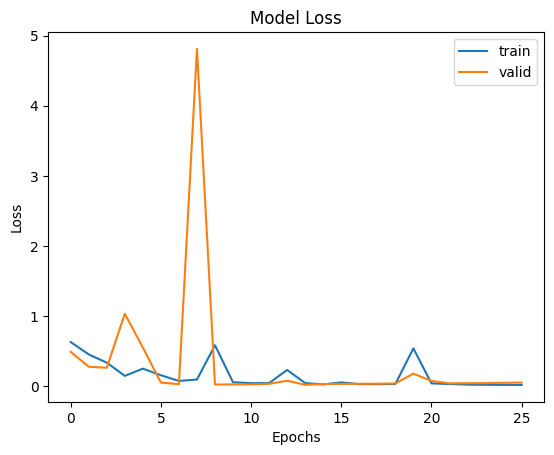

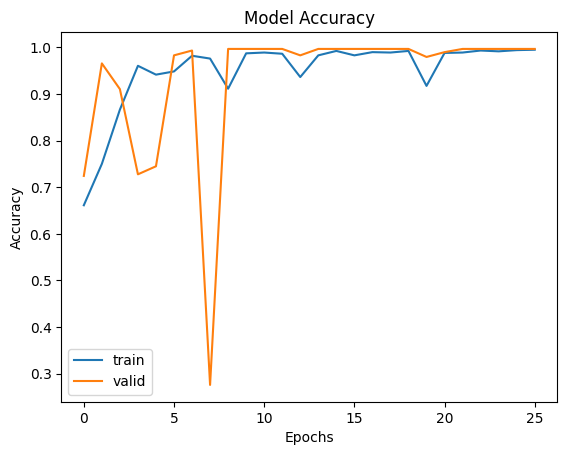

In [9]:
#Cell_10.
loss=fit_log.history['loss']
val_loss=fit_log.history['val_loss']
acc=fit_log.history['accuracy']
val_acc=fit_log.history['val_accuracy']
epoch=range(len(loss))

plt.plot(epoch, loss, label='train')
plt.plot(epoch, val_loss, label='valid')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epoch, acc, label='train')
plt.plot(epoch, val_acc, label='valid')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [10]:
#Cell_12.
score=model.evaluate(image_test, label_test_binary, verbose=0)
print('loss=', score[0])
print('accuracy=', score[1])

loss= 0.018581388518214226
accuracy= 0.997245192527771


In [11]:
#Cell_13.
y_test_pred=model.predict(image_test, verbose=0)
ct = pd.crosstab(label_test_binary.argmax(axis=1),
                 y_test_pred.argmax(axis=1))
display(ct)

col_0,0,1
row_0,,
0,98,1
1,0,264


In [12]:
#Cell_14.
# testデータの分類結果をcsvファイルに書き出し
f = open('./result_deep.csv', 'w')
writer = csv.writer(f, lineterminator='\n')

savedata = ['filename', 'true_class', 'estimate_class', 'estimate_likelihood_max', 'estimate_likelihood_class0', 'estimate_likelihood_class1']
writer.writerow(savedata)

for i in range(len(image_test)):
    savedata = [filenames_test[i], label_test[i], np.argmax(y_test_pred[i]), np.max(y_test_pred[i]), y_test_pred[i][0], y_test_pred[i][1]]
    writer.writerow(savedata)
    
f.close()